In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.utils import make_grid

# Local imports
from model import CCVAE
from dataset import CartoonHairColorDataset
from torchvision import transforms

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ccvae_haircolor_base.pth"
DATA_DIR = "./data/cartoonset10k/cartoonset10k"
BATCH_SIZE = 128

print(f"Working on {DEVICE}")

Working on cuda


In [2]:
# Dataset & Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = CartoonHairColorDataset(root_dir=DATA_DIR, transform=transform)
# Shuffle=True to have diverse classes
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)



In [3]:
model = CCVAE(img_channels=3, z_c_dim=16, z_not_c_dim=64, num_classes=10).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded and in eval() mode ")

data_iter = iter(test_loader)
fixed_x, fixed_y = next(data_iter)
fixed_x = fixed_x.to(DEVICE)
fixed_y = fixed_y.to(DEVICE)

Model loaded and in eval() mode 


## Basic blocks

In [4]:
def encode_to_z(model, x):
    """
    x : (1, 3, 64, 64)
    Returns :
        z, z_c, z_not_c  (tensors 1×dim)
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        logvar = model.fc_logvar(h)
        z = model.reparameterize(mu, logvar)

        z_c = z[:, :model.z_c_dim]
        z_not_c = z[:, model.z_c_dim:]

    return z, z_c, z_not_c

def probas_from_zc(model, z_c):
    """
    z_c : (1, z_c_dim)
    Returns probabilities q(y|z_c)
    """
    with torch.no_grad():
        logits = model.classifier(z_c)
        probs = F.softmax(logits, dim=1)
    return probs

def classify_x(model, x):
    """
    x : (1, 3, 64, 64)
    Returns :
        - pred (int)
        - probs (1, num_classes)
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        z_c = mu[:, :model.z_c_dim]

        logits = model.classifier(z_c)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    return pred, probs

def generate_random(model, device='cuda'):
    """
    Generates and image by sampling z_c and z_not_c ~ N(0,I)
    """
    with torch.no_grad():
        z_c = torch.randn(1, model.z_c_dim).to(device)
        z_not_c = torch.randn(1, model.z_not_c_dim).to(device)
        z = torch.cat([z_c, z_not_c], dim=1)

        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen

def generate_conditional(model, class_idx, device='cuda'):
    """
    Generates an image belonging to a specific class (hair_color = class_idx)
    """
    with torch.no_grad():
        y = torch.tensor([class_idx], device=device)
        y_onehot = F.one_hot(y, num_classes=model.num_classes).float()

        y_embed = model.y_embedding(y_onehot)
        z_c = model.cond_prior_mu(y_embed)   # moyenne du prior
        z_not_c = torch.randn(1, model.z_not_c_dim).to(device)

        z = torch.cat([z_c, z_not_c], dim=1)

        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_tensor_image(
    img_tensor,
    save_path=None,
    figsize=(2.5, 2.5),
    dpi=300
):
    """
    Display a tensor image.

    Parameters
    ----------
    img_tensor : torch.Tensor
        Shape (1, 3, H, W) or (3, H, W)
    save_path : str or None
        If provided, saves the figure (e.g. 'image.pdf')
    figsize : tuple
        Figure size in inches
    dpi : int
        Resolution (300 recommended for papers)
    """

    # --- Tensor to numpy ---
    img = img_tensor.detach().cpu()
    if img.dim() == 4:
        img = img.squeeze(0)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # --- Figure ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(img)
    ax.axis("off")

    # Remove margins
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

    plt.show()
    plt.close(fig)


In [6]:
# x_test=fixed_x
# On prend la 1ère image du dataset
x_test, y_test = dataset[0]
x_test = x_test.unsqueeze(0).to(DEVICE)
y_test = torch.tensor([y_test], device=DEVICE)

print(x_test.shape)
z,zc,z_not_c=encode_to_z(model,x_test)
print(z.shape)
print(zc.shape)
print(z_not_c.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 80])
torch.Size([1, 16])
torch.Size([1, 64])


In [7]:
probas_from_zc(model,zc).shape

torch.Size([1, 10])

In [8]:
print(classify_x(model,x_test))
print(y_test)

(9, tensor([[8.0476e-02, 1.2692e-03, 6.2022e-04, 1.3179e-04, 1.3595e-03, 1.2916e-04,
         1.8413e-05, 2.0146e-07, 5.2000e-02, 8.6400e-01]], device='cuda:0'))
tensor([9], device='cuda:0')


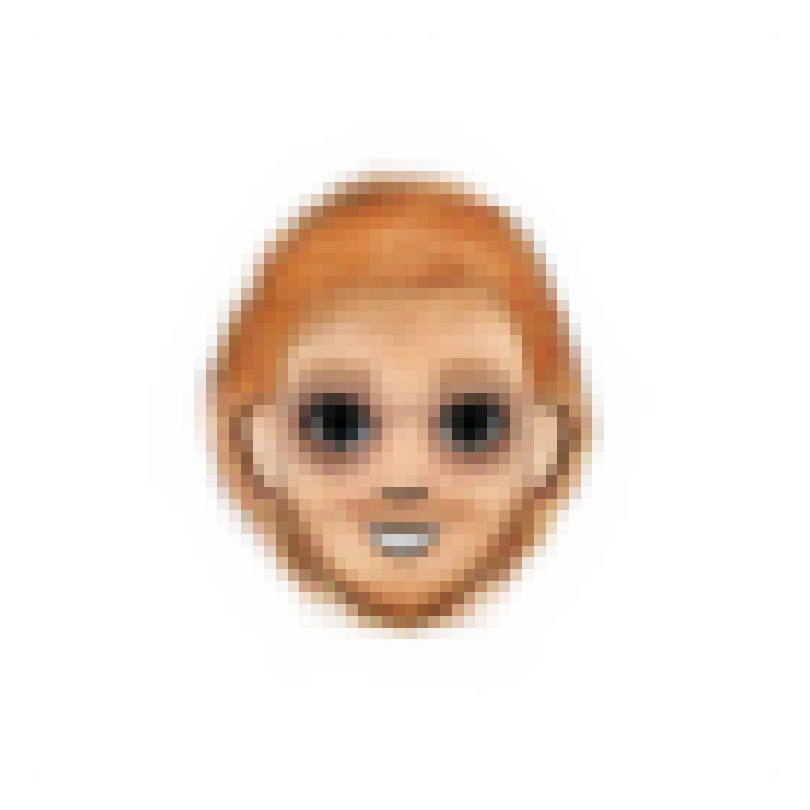

In [9]:
show_tensor_image(generate_conditional(model,2))

## Experiments

### Experiment 1 - Reconstruction Quality

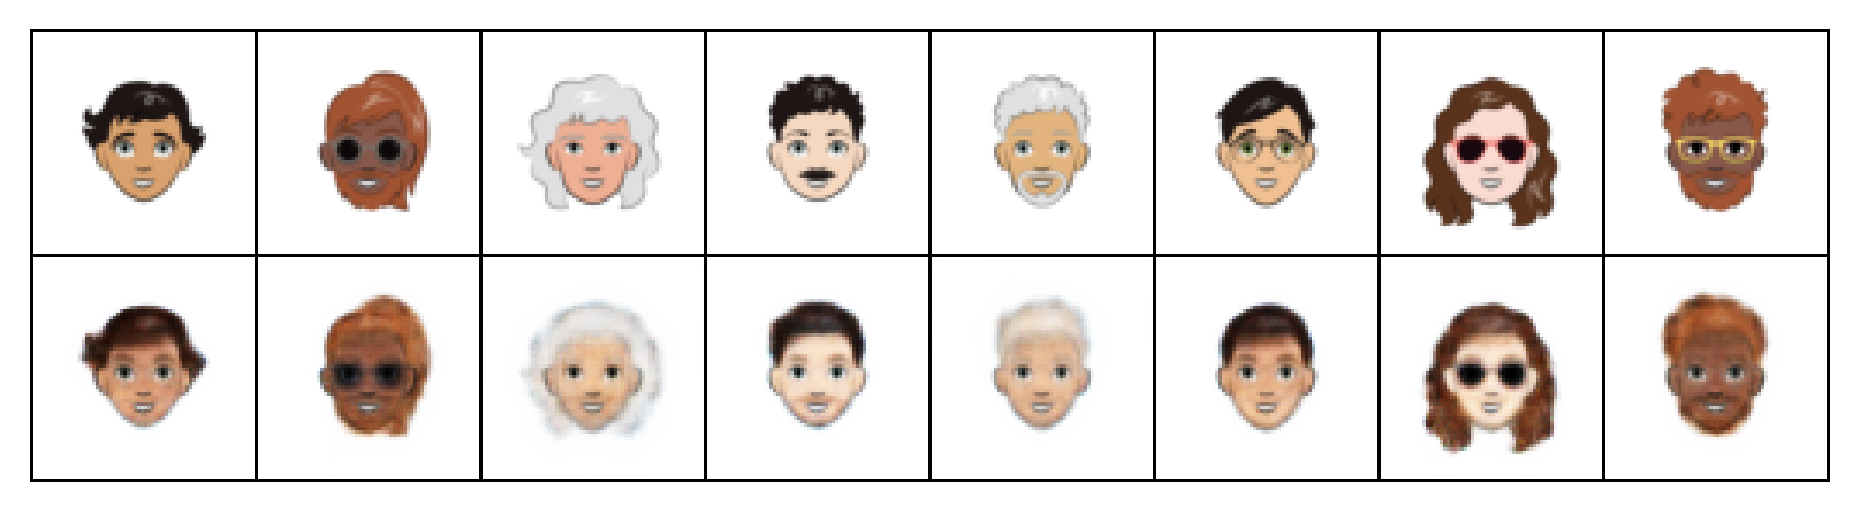

In [ ]:
from torchvision.utils import make_grid

def show_recons(
    x,
    model,
    n_samples=8,
    save_path=None,
    figsize=(6.0, 2.2),
    dpi=300
):
    """
    Display original images (top row) and reconstructions (bottom row)

    Parameters
    ----------
    x : torch.Tensor
        Input batch, shape (B, C, H, W)
    model : torch.nn.Module
        Trained CCVAE model
    n_samples : int
        Number of samples to display
    save_path : str or None
        If provided, saves figure (e.g. 'recon.pdf')
    figsize : tuple
        Figure size in inches
    dpi : int
        Figure resolution
    """

    model.eval()
    with torch.no_grad():
        recon_x, *_ = model(x)

    # Select samples
    x_vis = x[:n_samples]
    recon_vis = recon_x[:n_samples]

    # Stack: originals on top, reconstructions below
    comparison = torch.cat([x_vis, recon_vis], dim=0)

    # Grid (NO normalize=True unless strictly justified)
    grid = make_grid(
        comparison.cpu(),
        nrow=n_samples,
        padding=1
    )

    img = grid.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # Figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(img)
    ax.axis("off")

    # Tight layout, no margins
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

    plt.show()
    plt.close(fig)

show_recons(fixed_x, model)

### Experiment 2 - Latent Space Audit (t-SNE)

Extracts $z_c$ (caracteristics) vectors for all batch points and project in 2D with tSNE.

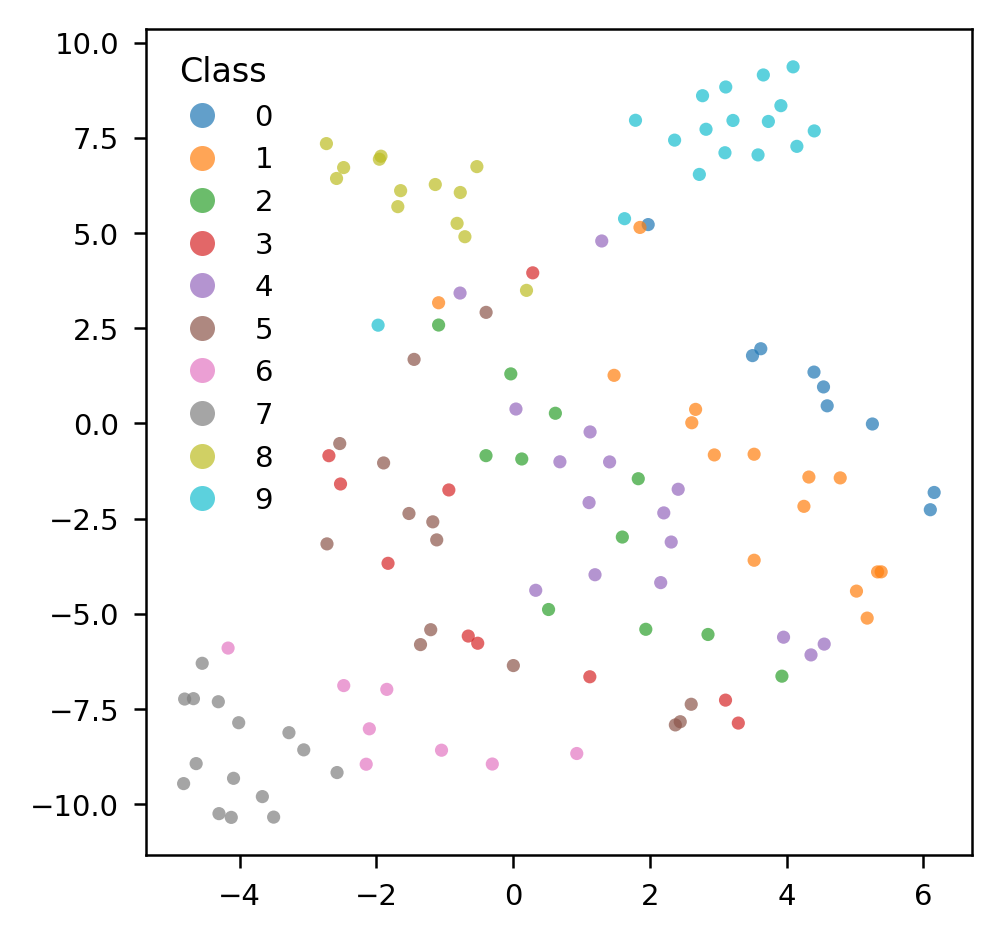

In [ ]:
def visualize_latent_space(
    x,
    y,
    model,
    perplexity=30,
    n_components=2,
    save_path=None,
    figsize=(3.2, 3.2),
    dpi=300
):
    """
    Visualize the characteristic latent space z_c using t-SNE.
    """

    model.eval()
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        z_c = mu[:, :model.z_c_dim].cpu().numpy()
        labels = y.cpu().numpy()

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=42,
        init="pca",
        learning_rate="auto"
    )
    z_embedded = tsne.fit_transform(z_c)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    scatter = ax.scatter(
        z_embedded[:, 0],
        z_embedded[:, 1],
        c=labels,
        cmap="tab10",
        s=10,
        alpha=0.7,
        linewidths=0
    )

    # Legend for categorical labels
    ax.legend(
        *scatter.legend_elements(),
        title="Class",
        loc="best",
        frameon=False,
        fontsize=7,
        title_fontsize=8
    )

    # --- Minimal axes styling ---
    ax.set_xlabel("")  # no semantic label
    ax.set_ylabel("")

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        length=3,
        width=0.6
    )

    for spine in ax.spines.values():
        spine.set_linewidth(0.6)

    ax.grid(False)

    fig.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.98)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

    plt.show()
    plt.close(fig)

visualize_latent_space(fixed_x, fixed_y, model)

### Experiment 3 - The "Swap Matrix"

The top row shows sources of style (color), while the left column shows sources of content (facial shape).
Each interior cell displays an image generated by combining the corresponding style and content latent variables.

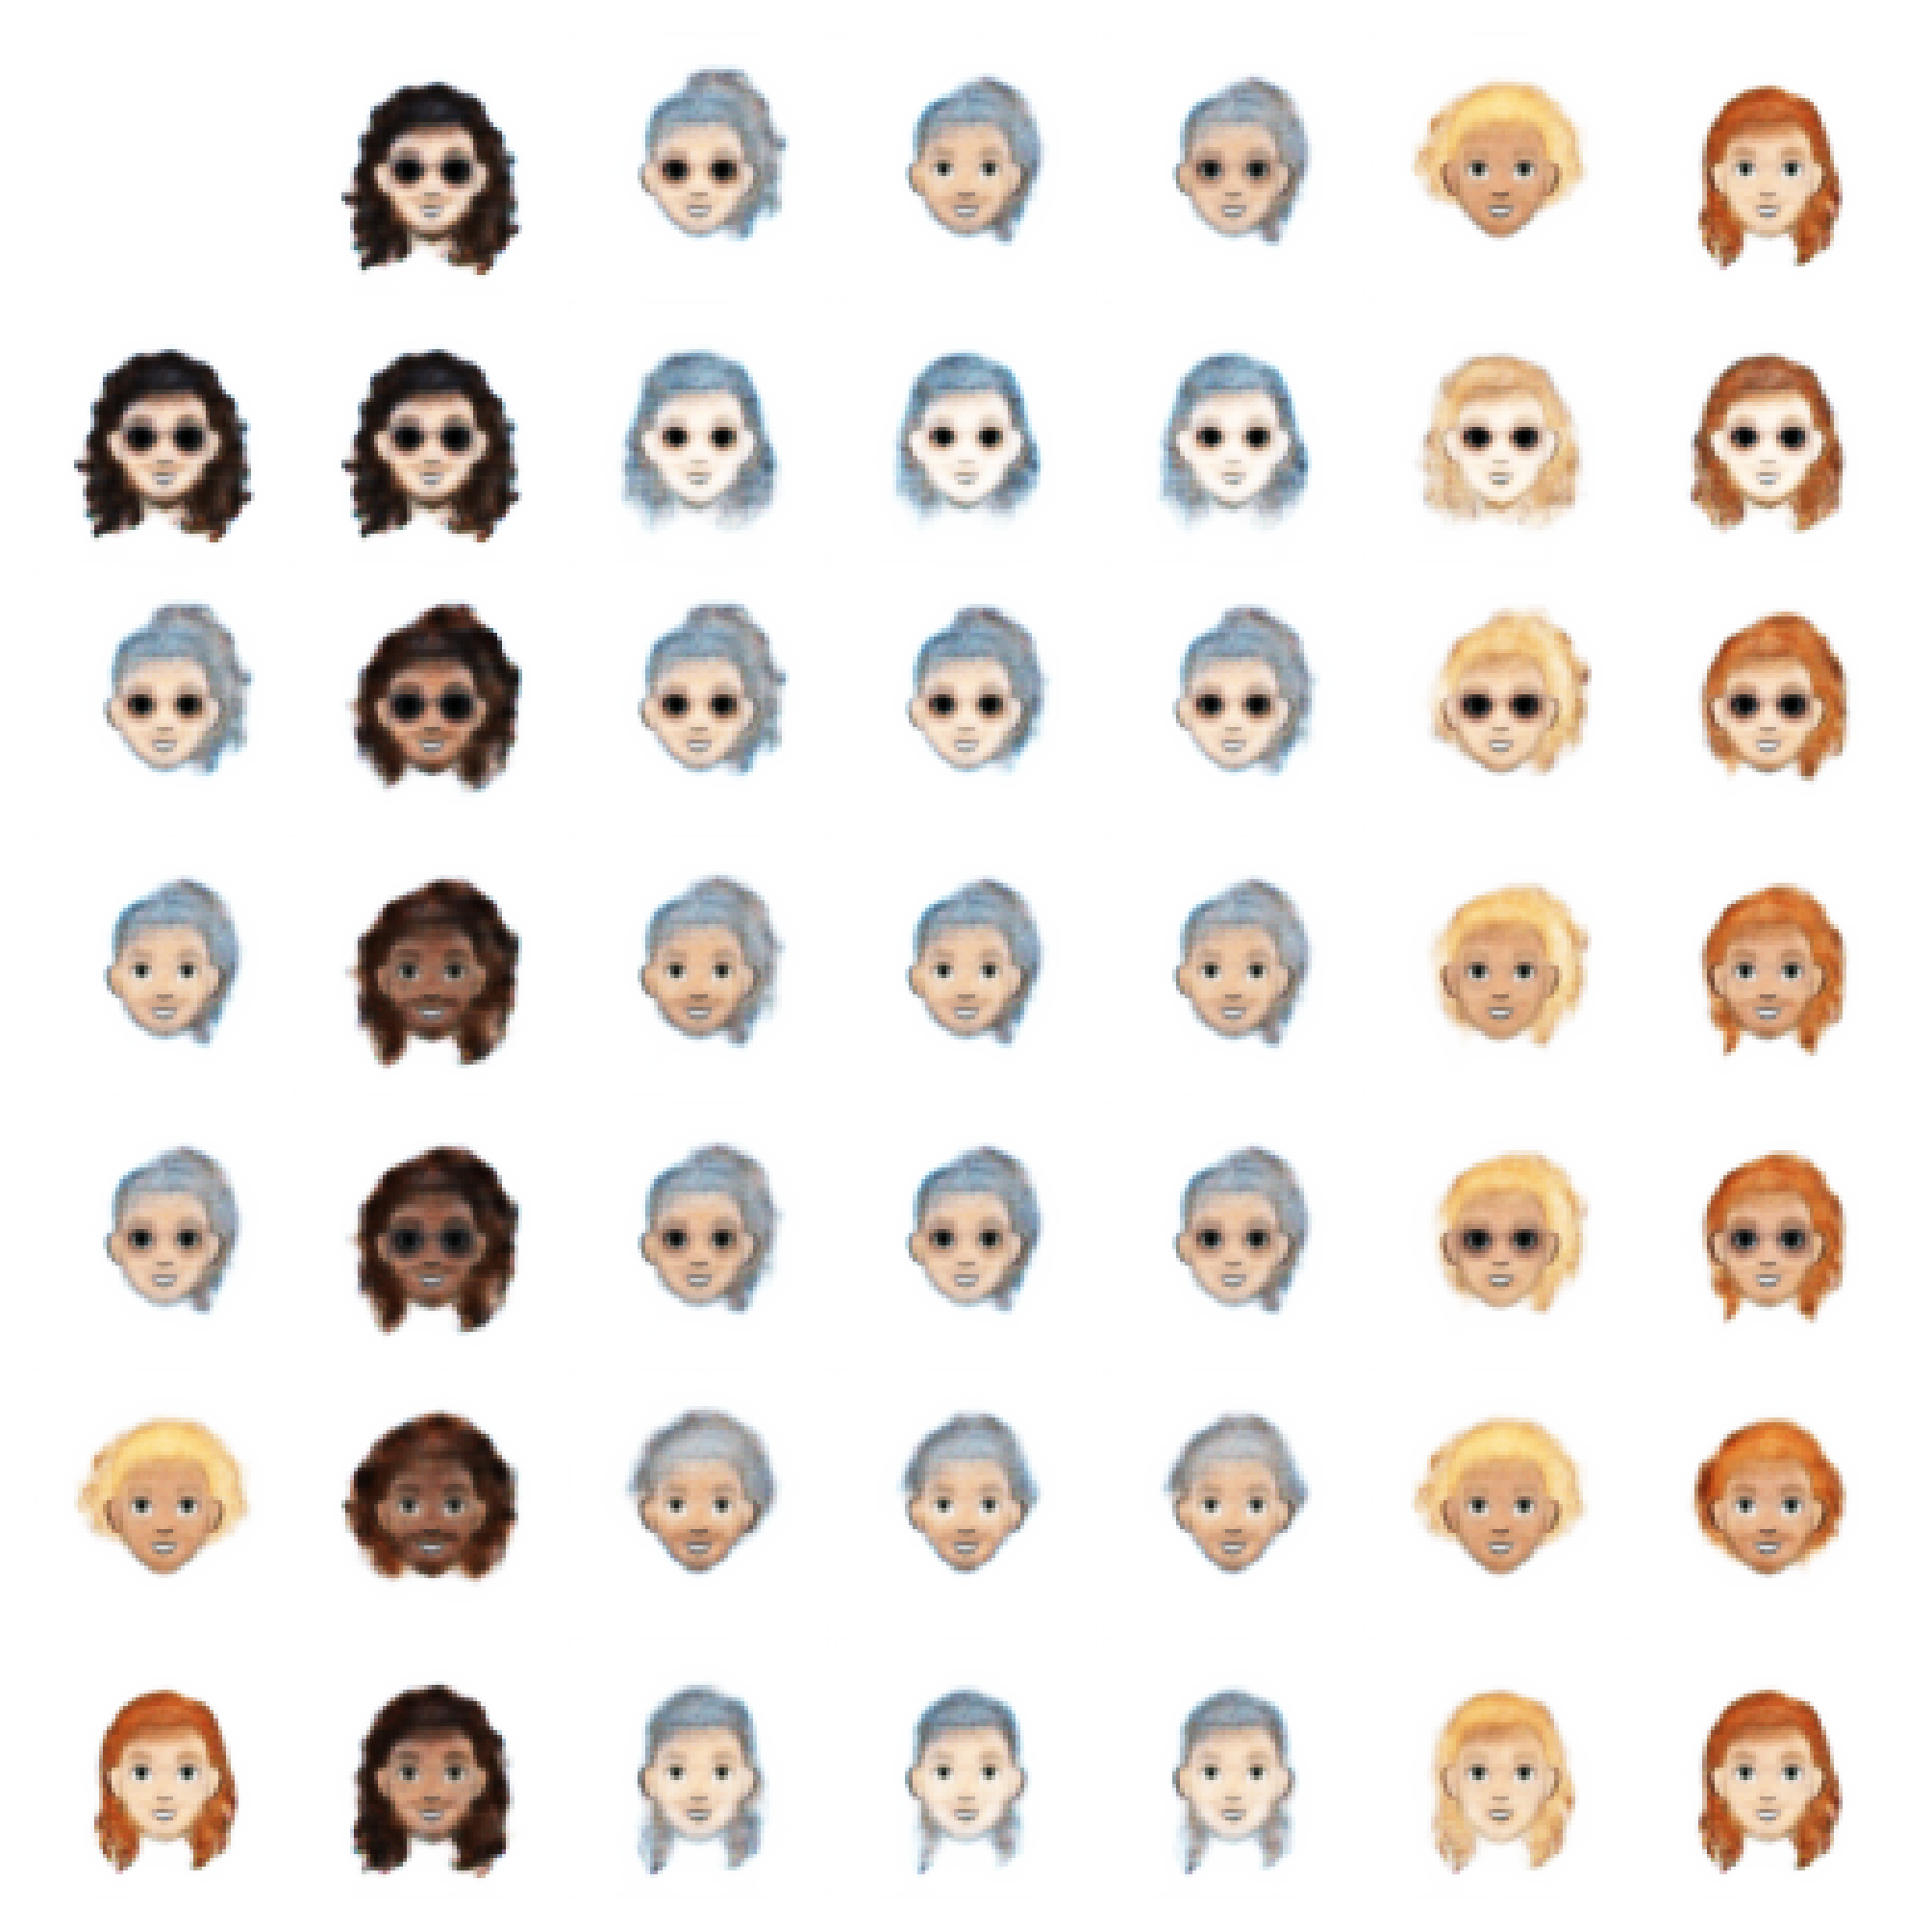

In [ ]:
def plot_disentanglement_matrix(
    model,
    dataset,
    num_examples=6,
    seed=42,
    save_path=None,
    figsize=(6.5, 6.5),
    dpi=300
):
    """
    Visualize disentanglement by combining:
    - Columns: characteristic factors (z_c, e.g. color)
    - Rows: non-characteristic factors (z_not_c, e.g. shape)

    The top row and left column show reference reconstructions.
    """

    model.eval()
    rng = np.random.default_rng(seed)

    # --- Sample inputs ---
    idxs = rng.choice(len(dataset), num_examples, replace=False)
    samples = torch.stack([dataset[i][0] for i in idxs]).to(next(model.parameters()).device)

    with torch.no_grad():
        # Encode
        h = model.encoder_conv(samples)
        mu = model.fc_mu(h)

        z_c_all = mu[:, :model.z_c_dim]
        z_not_c_all = mu[:, model.z_c_dim:]

        # Reference reconstructions
        dec_ref = model.decoder_input(mu).view(-1, 64, 4, 4)
        rec_originals = model.decoder_conv(dec_ref)

        rows = []

        # --- Header row (colors / z_c) ---
        white_square = torch.ones_like(samples[:1])
        header_row = torch.cat([white_square, rec_originals], dim=0)
        rows.append(header_row)

        # --- Disentanglement grid ---
        for i in range(num_examples):
            z_shape_i = z_not_c_all[i:i+1]
            z_shape_rep = z_shape_i.repeat(num_examples, 1)

            z_combined = torch.cat([z_c_all, z_shape_rep], dim=1)
            dec_in = model.decoder_input(z_combined).view(-1, 64, 4, 4)
            generated = model.decoder_conv(dec_in)

            row_i = torch.cat([rec_originals[i:i+1], generated], dim=0)
            rows.append(row_i)

        final_tensor = torch.cat(rows, dim=0)

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    grid = make_grid(
        final_tensor.cpu(),
        nrow=num_examples + 1,
        padding=1,
        pad_value=1.0
    )

    img = grid.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis("off")

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

    plt.show()
    plt.close(fig)

plot_disentanglement_matrix(model, dataset)